# PCA Visualization

#### Imports

In [13]:
import torch
import numpy as np
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


#### Load the Dataset

In [2]:
xset = np.load("Xset.npy")  # Shape: (num_images, 128, 128)
yset = np.load("Yset.npy")  # Shape: (num_images, num_classes=10)

lego_Y_labels = [3001, 3003, 3023, 3794, 4150, 4286, 6632, 18654, 43093, 54200]

x_train, x_test, y_train, y_test = train_test_split(xset, yset, test_size=0.3, random_state=42, shuffle=True)

# Results
print(f"Training set: X={x_train.shape}, Y={y_train.shape}")
print(f"Testing set: X={x_test.shape}, Y={y_test.shape}")

Training set: X=(5600, 128, 128), Y=(5600, 10)
Testing set: X=(2400, 128, 128), Y=(2400, 10)


In [ ]:
subset_size = int(0.7*len(x_train))  # For example, take 100 images

# Randomly select indices
indices = np.random.choice(len(x_train), size=subset_size, replace=False)

# Select the subset based on the indices
x_train_subset = x_train[indices]
y_train_subset = y_train[indices]


#### PCA Visual of Images in 2D Space

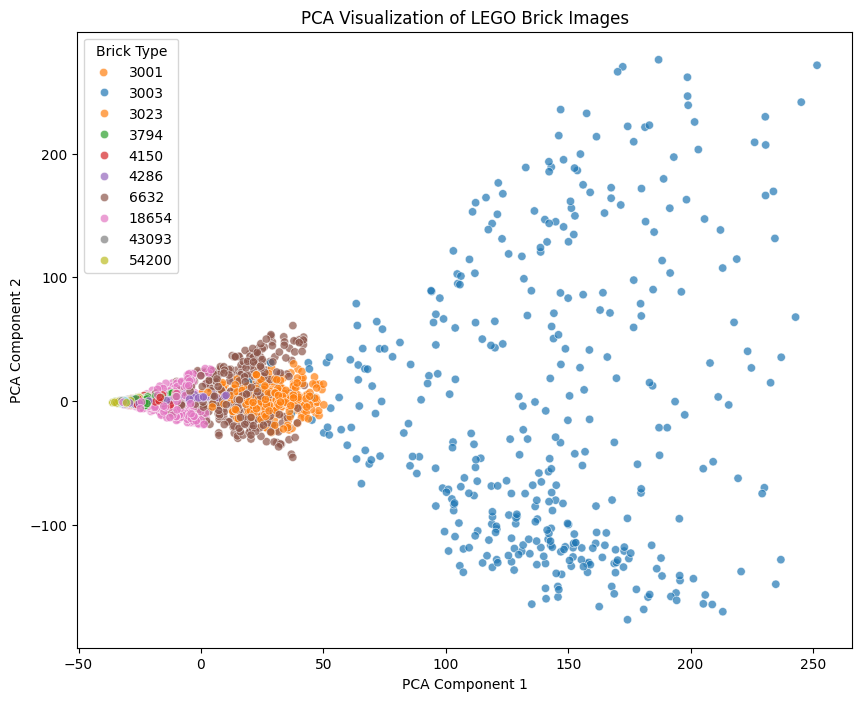

In [4]:
# Flatten each image into a 1D vector (from 128x128 to 16384)
num_samples = x_train_subset.shape[0]
flattened_images = x_train_subset.reshape(num_samples, -1) 

# Convert one-hot encoded labels back to class indices
labels = np.argmax(y_train_subset, axis=1) 

# Standardize the image data for better PCA performance
scaler = StandardScaler()
flattened_images_scaled = scaler.fit_transform(flattened_images)

# Apply PCA to reduce to 2D
pca = PCA(n_components=2)
pca_result = pca.fit_transform(flattened_images_scaled)

# Plot the PCA visualization
plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette="tab10", alpha=0.7)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of LEGO Brick Images")
plt.legend(lego_Y_labels, title="Brick Type")
plt.show()


#### PCA Visual of Image Embeddings

#### Pre-Trained MobileNetV2 PCA Visual 

In [5]:
# To use Mobile Net, convert the images to 3 channels
x_train = torch.tensor(x_train_subset, dtype=torch.float32).unsqueeze(1).repeat(1, 3, 1, 1) / 255.0  # Normalize & Convert to 3 channels
y_train = torch.tensor(y_train_subset, dtype=torch.float32)

In [6]:
model = models.mobilenet_v2(pretrained=True) 

model.classifier = nn.Identity()  

model.eval()

def extract_embeddings(model, x_train):
    with torch.no_grad():  
        embeddings = model(x_train)  
    return embeddings


# Extract embeddings
embeddings = extract_embeddings(model, x_train)
embeddings_numpy = embeddings.cpu().numpy()  

# Save embeddings and labels as .npy files
np.save("embeddings_pretrainedmobilenet.npy", embeddings_numpy)

C:\Users\haley\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\haley\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


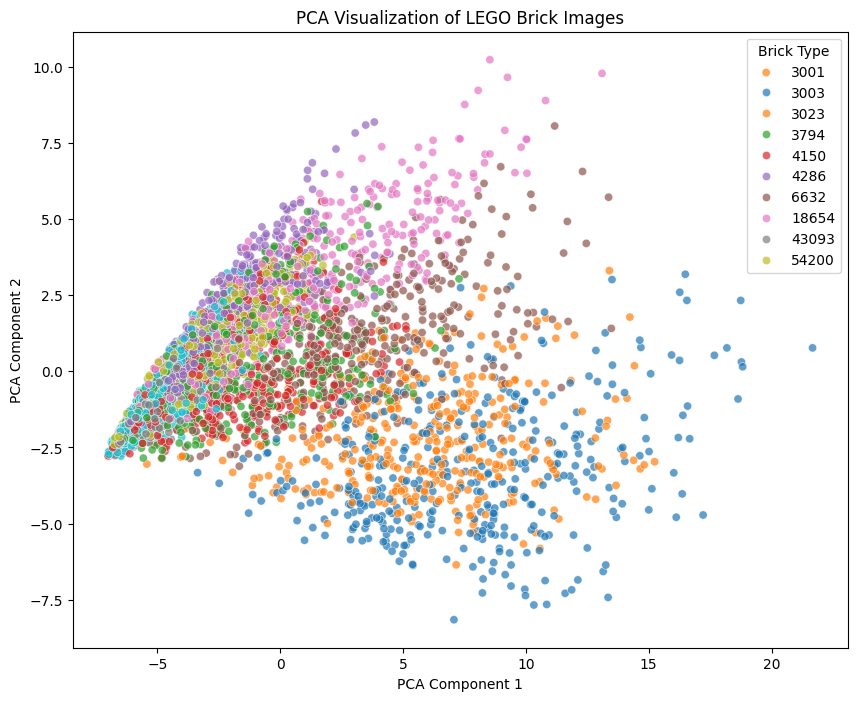

In [7]:
# Define PCA transformation
pca = PCA(n_components=2)  # Reduce to 3D
pca_result = pca.fit_transform(embeddings.numpy())

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette="tab10", alpha=0.7)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of LEGO Brick Images")
plt.legend(lego_Y_labels, title="Brick Type")
plt.show()


#### Pre-Trained MobileNetV2 Trained on Dataset - PCA Visual 

In [10]:
x_train = torch.tensor(x_train_subset, dtype=torch.float32).unsqueeze(1).repeat(1, 3, 1, 1) / 255.0  # Normalize & Convert to 3 channels
y_train = torch.tensor(y_train_subset, dtype=torch.long)
y_train = torch.argmax(y_train, dim=1)


train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [12]:
model = models.mobilenet_v2(pretrained=True)  # Load pretrained MobileNetV2

model.classifier = nn.Identity()  # Remove the last layer (classifier)

model.eval()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)  
        loss = criterion(outputs, labels)
        loss.backward()  
        optimizer.step() 
        running_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss/len(train_loader)}")


Epoch [1/10], Loss: 3.992720538038548
Epoch [2/10], Loss: 2.9920706051151926
Epoch [3/10], Loss: 2.6697795972591494
Epoch [4/10], Loss: 2.347718610996153
Epoch [5/10], Loss: 2.164428200178999
Epoch [6/10], Loss: 2.0041560283521327
Epoch [7/10], Loss: 1.8781978909562274
Epoch [8/10], Loss: 1.7805284503998795
Epoch [9/10], Loss: 1.7177868781051016
Epoch [10/10], Loss: 1.7122937111350578


In [14]:
def extract_embeddings(model, x_train):
    with torch.no_grad():  
        embeddings = model(x_train)  
    return embeddings

embeddings = extract_embeddings(model, x_train)
embeddings_numpy = embeddings.cpu().numpy() 
np.save("embeddings_mobilenet_trained_lego.npy", embeddings_numpy)

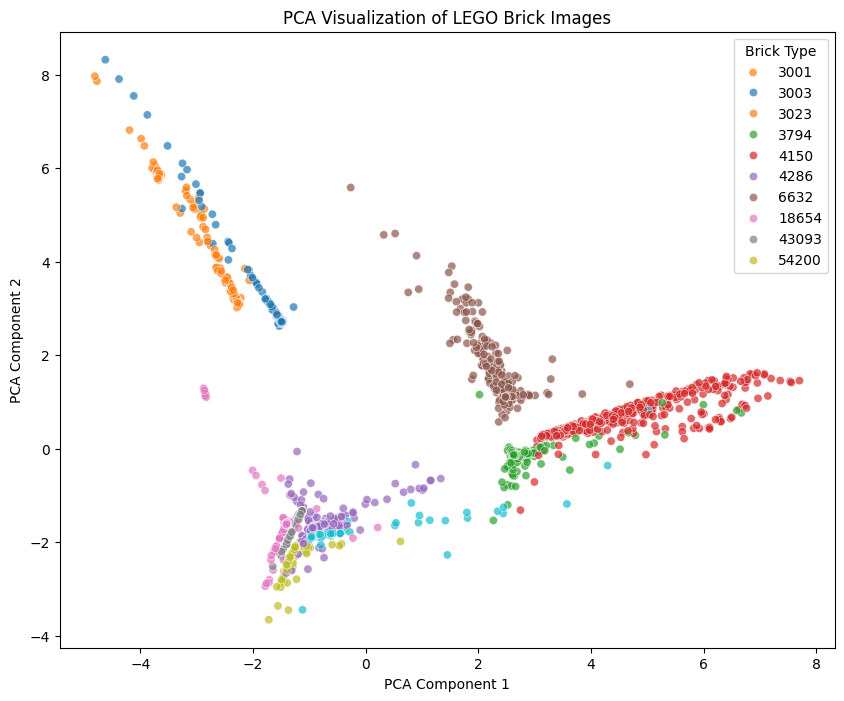

In [17]:
# Define PCA transformation
labels = np.argmax(y_train_subset, axis=1) 

pca = PCA(n_components=2)  # Reduce to 3D
pca_result = pca.fit_transform(embeddings.numpy())

plt.figure(figsize=(10, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=labels, palette="tab10", alpha=0.7)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of LEGO Brick Images")
plt.legend(lego_Y_labels, title="Brick Type")
plt.show()